In [ ]:
%pip install keras_tuner

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [53]:
import os
import pandas as  pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
import keras
from tensorflow.keras import layers
import keras_tuner
import datetime

In [11]:
files = os.listdir('../final_stats/preprocessed_3/')
# no_sent_files = files[:7]
files[0]

'preprocessed_no_sent_last_1.csv'

### File Retrieval and Preprocessing

In [12]:
def split_target(df, target_col='away_winner_wts'):
    df = df.copy()
    target = df.pop(target_col)
    return df, target

def normalize_df(df):
    scaler = StandardScaler()
    data, target = split_target(df)
    data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
    return data, target

def get_data(file):
    df = pd.read_csv(f'../final_stats/preprocessed_3/{file}', index_col=[0])
    data, target = normalize_df(df)
    return data, target

def shuffle_data(x,y, seed):
    x_shuffle = x.sample(frac=1, random_state=seed)
    y_shuffle = y.sample(frac=1, random_state=seed)
    return x_shuffle, y_shuffle


### Chart Code

In [4]:
def get_average_acc_history(acc_histories):
    num_epochs = len(acc_histories[0])
    return [np.mean([x[i] for x in acc_histories]) for i in range(num_epochs)]

def get_average_loss_history(loss_histories):
    num_epochs = len(loss_histories[0])
    return [np.mean([x[i] for x in loss_histories]) for i in range(num_epochs)]
        
def plot_ave_acc_and_loss_histories(acc_histories, loss_histories):
    average_acc_history = get_average_acc_history(acc_histories)
    average_loss_history = get_average_loss_history(loss_histories)

    plt.figure(figsize=(15,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(average_acc_history) + 1), average_acc_history)
    plt.xlabel("Epochs")
    plt.ylabel("Validation Accuracy")

    plt.subplot(1, 2, 2)

    plt.plot(range(1, len(average_loss_history) + 1), average_loss_history)
    plt.xlabel("Epochs")
    plt.ylabel("Validation Loss")
    plt.show()

def compare_ave_loss_acc_histories(acc_hist_1, acc_hist_2, loss_hist_1, loss_hist_2):
    min_epochs = min(len(acc_hist_1[0]), len(acc_hist_2[0]))
    
    ave_acc_hist_1 = get_average_acc_history(acc_hist_1)
    ave_loss_hist_1 = get_average_loss_history(loss_hist_1)
    
    ave_acc_hist_2 = get_average_acc_history(acc_hist_2)
    ave_loss_hist_2 = get_average_loss_history(loss_hist_2)


    blue_dots = 'bo'
    solid_blue_line = 'b'
    red_dots = 'ro'
    solid_red_line = 'r'

    epochs = range(1, min_epochs + 1)
    plt.figure(figsize=(15,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, ave_acc_hist_1, solid_blue_line, label='Model 1')
    plt.plot(epochs, ave_acc_hist_2, solid_red_line, label='Model 2')
    plt.xlabel("Epochs")
    plt.ylabel("Validation Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)

    plt.plot(epochs, ave_loss_hist_1, solid_blue_line, label='Model 1')
    plt.plot(epochs, ave_loss_hist_2, solid_red_line, label='Model 2')
    plt.xlabel("Epochs")
    plt.ylabel("Validation Loss")
    plt.legend()
    
    plt.show()
    

### Helper Functions


In [134]:
def get_max_ave_acc_min_ave_loss(acc_histories, loss_histories):
    num_epochs = len(acc_histories[0])
    average_acc_history = [
        np.mean([x[i] for x in acc_histories]) for i in range(num_epochs)
    ]
    index_acc = np.argmax(average_acc_history)
    max_acc = round(average_acc_history[index_acc]*100,2)
    print(f'\nMax Average Accuracy: {max_acc}% \t Num Epochs: {index_acc + 1} ')

    average_loss_history = [
        np.mean([x[i] for x in loss_histories]) for i in range(num_epochs)
    ]
    index_loss = np.argmin(average_loss_history)
    min_loss = round(average_loss_history[index_loss], 2)
    print(f'Min Average Loss: {min_loss} \t Num Epochs: {index_loss + 1} ')
    return min_loss, max_acc

### Build Models

In [109]:
def build_custom_model(hps):
    model = keras.Sequential()
    for n in range(hps[0]):
        model.add(layers.Dense(hps[1], activation='tanh'))
        model.add(layers.Dropout(hps[2]))

    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer = keras.optimizers.Adam(learning_rate=hps[3]),
        loss = 'binary_crossentropy',
        metrics='accuracy'
    )
    return model

In [56]:
def build_model(units, activation, dropout_layers, dropout_single, lr, loss):
    model = keras.Sequential()

    for unit in units:
        model.add(layers.Dense(unit), activation=activation)
        if dropout_layers > 0:
            model.add(layers.Dropout(dropout_layers))

    if dropout_single > 0:
        model.add(layers.Dropout(dropout_single))

    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr), 
        loss=loss,
        metrics=['accuracy']
    )
    
    return model
    

In [58]:
do_rates = [0.8, 0.3, 0.6]
activations = ['tanh']
lrs = [5.23e-3,5.323E-03,2.816E-02,4.226E-02,6.019E-03,2.430E-02]
loss_funcs = ['binary_crossentropy', 'binary_focal_crossentropy']
unit_layers = [
    [880, 1968, 1808, 2032],
    [1424,	1168,	304,	1008,	1360,	80],
    [368,	688,	1872,	208,	1456,	1968,	784,	1360,	528,],
    [1488,	1840,	1200,	112,],
    [1328,	976,	496,	1008,	1488,	1232,],
]
total = len(do_rates)*len(activations)*len(lrs)*len(loss_funcs)*len(unit_layers)
total

180

In [92]:
np.mean(lrs)

0.018548666666666665

In [61]:
model_params = [

{'num_layers': 4,	'activation': 'tanh',	'dropout': False, 	'do_rate': 0.3, 'learn_rate':	5.323E-03,	'loss_func': 'binary_crossentropy',	        'units': [880 ,1968, 1808, 2032, 752, 2000, 688, 112,  1328, 304],	'Score': 0.8571428656578064},
{'num_layers': 6,	'activation': 'tanh',	'dropout': False, 	'do_rate': 0.7, 'learn_rate':	2.816E-02,	'loss_func': 'binary_crossentropy',	        'units': [1424 ,1168, 304, 1008, 1360, 80, 1744, 16,  368, 1136],	    'Score': 0.8571428656578064},
{'num_layers': 9,	'activation': 'relu',	'dropout': True, 	'do_rate': 0.8, 'learn_rate':	4.226E-02,	'loss_func': 'binary_focal_crossentropy',	'units': [368 ,688, 1872, 208, 1456, 1968, 784, 1360,  528, 1680],	'Score': 0.8095238208770752},
{'num_layers': 4,	'activation': 'tanh',	'dropout': False, 	'do_rate': 0.4, 'learn_rate':	6.019E-03,	'loss_func': 'binary_focal_crossentropy',	'units': [1488 ,1840, 1200, 112, 1872, 560, 1872, 432,  112, 432],	    'Score': 0.8095238208770752},
{'num_layers': 6,	'activation': 'tanh',	'dropout': False, 	'do_rate': 0.3, 'learn_rate':	2.430E-02,	'loss_func': 'binary_crossentropy',	        'units': [1328 ,976, 496, 1008, 1488, 1232, 1424, 16,  1360, 1744],	'Score': 0.8095238208770752},
{'num_layers': 7,	'activation': 'relu',	'dropout': True, 	'do_rate': 0.3, 'learn_rate':	3.478E-05,	'loss_func': 'binary_crossentropy',	        'units': [1744 ,1424, 752, 1936, 656, 720, 1872, 1584,  304, 2000],	'Score': 0.761904776096344},
{'num_layers': 7,	'activation': 'tanh',	'dropout': True, 	'do_rate': 0.6, 'learn_rate':	8.232E-03,	'loss_func': 'binary_focal_crossentropy',	'units': [16 ,848, 400, 1904, 1584, 1264, 1808, 976,  464, 1776],	'Score': 0.761904776096344},
{'num_layers': 8,	'activation': 'tanh',	'dropout': False, 	'do_rate': 0.5, 'learn_rate':	7.624E-04,	'loss_func': 'binary_crossentropy',	        'units': [1296 ,816, 944, 1936, 1136, 1744, 1680, 1936,  1328, 784],	'Score': 0.761904776096344},
{'num_layers': 7,	'activation': 'tanh',	'dropout': False, 	'do_rate': 0.1, 'learn_rate':	9.883E-02,	'loss_func': 'binary_crossentropy',	        'units': [144 ,1392, 1392, 1424, 304, 1552, 336, 240,  1584, 16],	    'Score': 0.761904776096344},
{'num_layers': 9,	'activation': 'tanh',	'dropout': True, 	'do_rate': 0.3, 'learn_rate':	1.085E-02,	'loss_func': 'binary_crossentropy',	        'units': [1360 ,720, 1232, 1072, 1904, 528, 848, 1680,  1616, 1424],	'Score': 0.761904776096344}
]
custom_params = [
    {'num_layers': 9,	'activation': 'tanh',	'dropout': True, 	'do_rate': 0.3, 'learn_rate':	1.085E-02,	'loss_func': 'binary_crossentropy',	        'units': [1360 ,720, 1232, 1072, 1904, 528, 848, 1680,  1616, 1424],	'Score': 0.761904776096344}
    
]

In [63]:
def model_contstructor(pd):
    model = keras.Sequential()
    # dense layers
    for i in range(pd['num_layers']):
        model.add(
            layers.Dense(
                units = pd['units'][i] ,
                activation= pd['activation']
            )   
        )
        if pd['dropout']:
            model.add(layers.Dropout(
                rate=pd['do_rate']
            )
        )
    # output layer
    model.add(layers.Dense(1, activation='sigmoid'))

    #learning rate
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=pd['learn_rate']), 
        loss=pd['loss_func'],
        metrics=['accuracy']
    )

    return model

modela = model_contstructor(model_params[0])
    

In [145]:
def get_val_and_train(data, i, num_val_samples):
    val = data[i * num_val_samples: (i + 1) * num_val_samples]
    train = np.concatenate(
                    [data[:i * num_val_samples],
                    data[(i + 1) * num_val_samples:]],
                    axis=0
                )
    return val, train


def run_k_fold_params(x, y, build_m, params, num_epochs=30, k=10, n_repeats=10):
    num_val_samples = len(x) // k
    all_scores = [] 
    
    all_histories = []
    acc_histories = []
    loss_histories = []
    curr_fold = 0
    total_folds = k*n_repeats
    # cv = RepeatedKFold(10, 10, 99)
    for n in range(n_repeats):
        xs, ys = shuffle_data(x,y,n)
        for i in range(k):
            curr_fold = curr_fold + 1
            if curr_fold % 10 == 0:
                print(f"Fold {curr_fold}/{total_folds}")
 
            X_val, X_train = get_val_and_train(xs, i, num_val_samples)
            y_val, y_train = get_val_and_train(ys, i, num_val_samples)

            model = build_m(params)
            
            history = model.fit(
                    X_train, y_train, 
                    validation_data=(X_val, y_val),
                    epochs=num_epochs, batch_size=16, verbose=0
                )
            
            all_histories.append(history.history)
            acc_histories.append(history.history['val_accuracy'])
            loss_histories.append(history.history['val_loss'])

    # get_max_ave_acc_min_ave_loss(acc_histories, loss_histories)
    # plot_ave_acc_and_loss_histories(acc_histories, loss_histories)
    return [all_histories, acc_histories, loss_histories]

In [144]:
def run_k_fold_custom(x, y, build_m, num_epochs=30, k=10, n_repeats=10):
    num_val_samples = len(x) // k
    all_scores = [] 
    
    all_histories = []
    acc_histories = []
    loss_histories = []
    curr_fold = 0
    total_folds = k*n_repeats
    # cv = RepeatedKFold(10, 10, 99)
    for n in range(n_repeats):
        xs, ys = shuffle_data(x,y,n)
        for i in range(k):
            curr_fold = curr_fold + 1
            if curr_fold % 10 == 0:
                print(f"Fold {curr_fold}/{total_folds}")
 
            X_val, X_train = get_val_and_train(xs, i, num_val_samples)
            y_val, y_train = get_val_and_train(ys, i, num_val_samples)

            model = build_m()
            
            history = model.fit(
                    X_train, y_train, 
                    validation_data=(X_val, y_val),
                    epochs=num_epochs, batch_size=16, verbose=0
                )
            
            all_histories.append(history.history)
            acc_histories.append(history.history['val_accuracy'])
            loss_histories.append(history.history['val_loss'])

    # get_max_ave_acc_min_ave_loss(acc_histories, loss_histories)
    # plot_ave_acc_and_loss_histories(acc_histories, loss_histories)
    return [all_histories, acc_histories, loss_histories]

### 4 layers 512 units 0.3 dropout each layer

Fold 10/50
Fold 20/50
Fold 30/50
Fold 40/50
Fold 50/50

Max Average Accuracy: 52.8% 	 Num Epochs: 15 
Min Average Loss: 1.05 	 Num Epochs: 7 


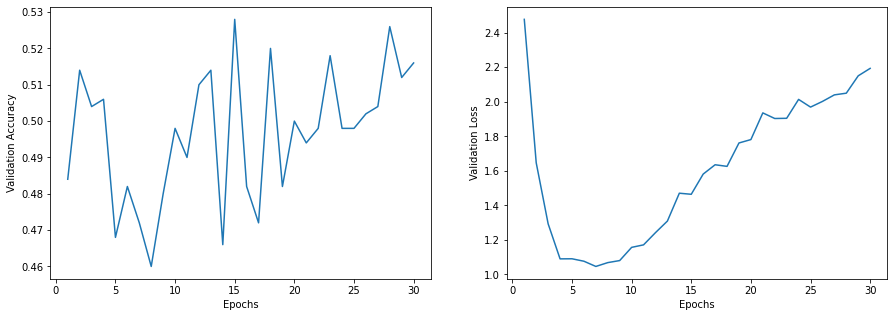

In [106]:
x,y = get_data(files[0])
hist_custom_1 = run_k_fold_custom(x, y, build_custom_model, 30, 10, 5)

### 6 layers 512 units 0.3 dropout each layer
56.2

Fold 10/50
Fold 20/50
Fold 30/50
Fold 40/50
Fold 50/50

Max Average Accuracy: 56.2% 	 Num Epochs: 20 
Min Average Loss: 0.87 	 Num Epochs: 8 


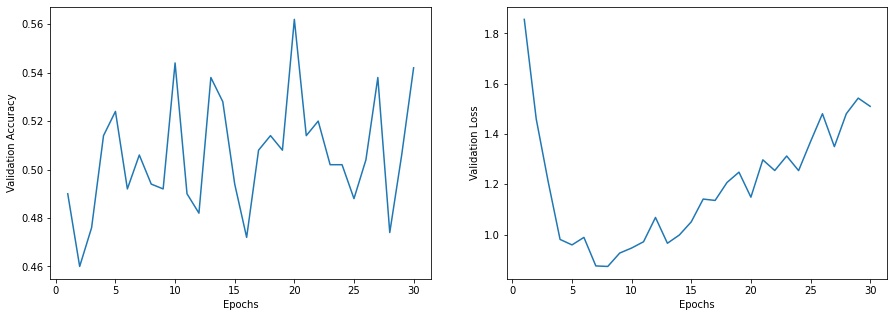

In [110]:
params2 = [6, 512, 0.3, 0.018548666666666665]
hist_custom_2 = run_k_fold_params(x, y, build_custom_model, params2, 30, 10, 5)

### 8 layers 512 units 0.3 dropout each layer
53.8

Fold 10/50
Fold 20/50
Fold 30/50
Fold 40/50
Fold 50/50

Max Average Accuracy: 53.8% 	 Num Epochs: 28 
Min Average Loss: 0.82 	 Num Epochs: 13 


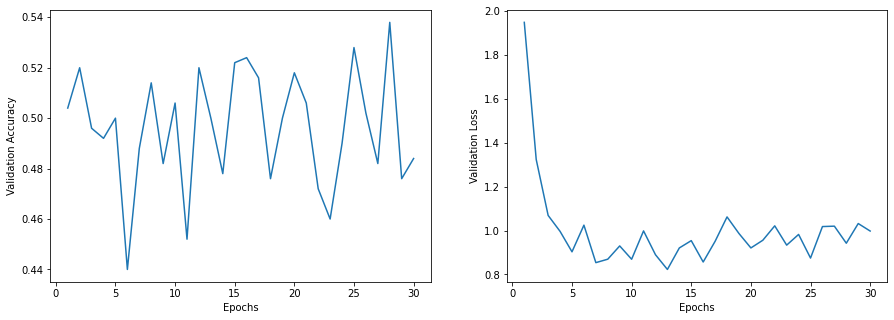

In [111]:
params3 = [8, 512, 0.3, 0.018548666666666665]
hist_custom_2 = run_k_fold_params(x, y, build_custom_model, params3, 30, 10, 5)


### 6 layers 512 units 0.5 dropout each layer
51.8

Fold 10/50
Fold 20/50
Fold 30/50
Fold 40/50
Fold 50/50

Max Average Accuracy: 51.8% 	 Num Epochs: 13 
Min Average Loss: 1.02 	 Num Epochs: 5 


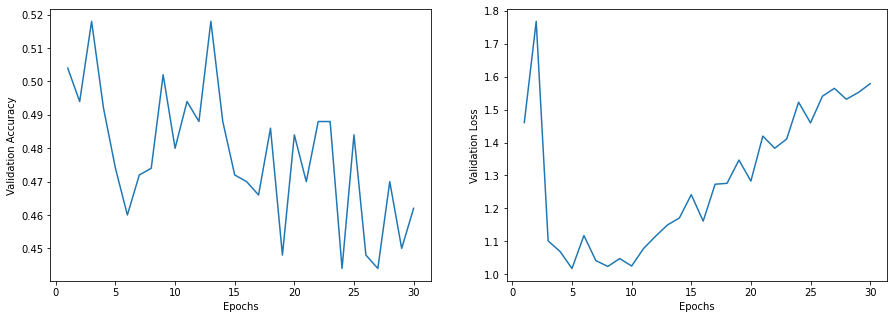

In [113]:
params4 = [6, 512, 0.5, 0.018548666666666665]
hist_custom_4 = run_k_fold_params(x, y, build_custom_model, params4, 30, 10, 5)

### 6 layers 512 units 0.1 dropout each layer
54.8

Fold 10/50
Fold 20/50
Fold 30/50
Fold 40/50
Fold 50/50

Max Average Accuracy: 54.8% 	 Num Epochs: 18 
Min Average Loss: 0.91 	 Num Epochs: 5 


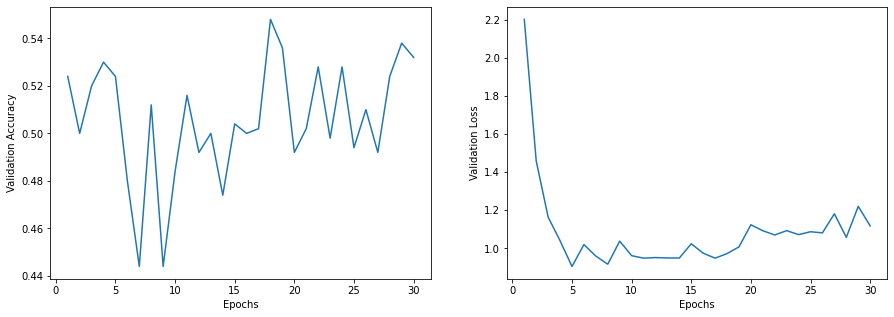

In [115]:
params5 = [6, 512, 0.1, 0.018548666666666665]
hist_custom_5 = run_k_fold_params(x, y, build_custom_model, params5, 30, 10, 5)

Fold 10/50
Fold 20/50
Fold 30/50
Fold 40/50
Fold 50/50

Max Average Accuracy: 54.0% 	 Num Epochs: 1 
Min Average Loss: 0.88 	 Num Epochs: 15 


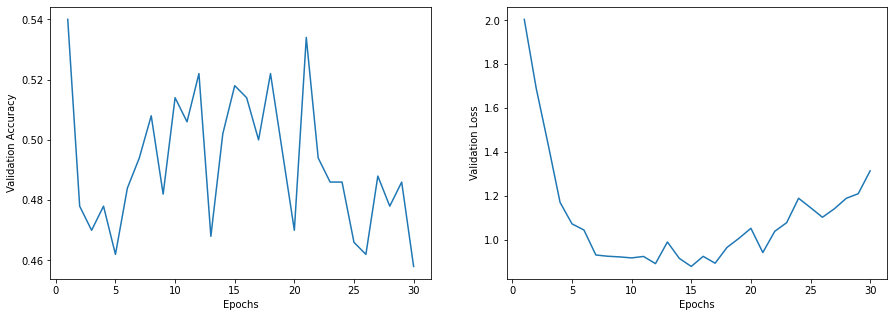

In [117]:
### 6 layers 512 units 0.4 dropout each layer
params6 = [6, 512, 0.4, 0.018548666666666665]
hist_custom_6 = run_k_fold_params(x, y, build_custom_model, params5, 30, 10, 5)

### 6 layers 512 units 0.2 dropout each layer
56.8%


Fold 10/50
Fold 20/50
Fold 30/50
Fold 40/50
Fold 50/50

Max Average Accuracy: 56.0% 	 Num Epochs: 3 
Min Average Loss: 0.88 	 Num Epochs: 6 


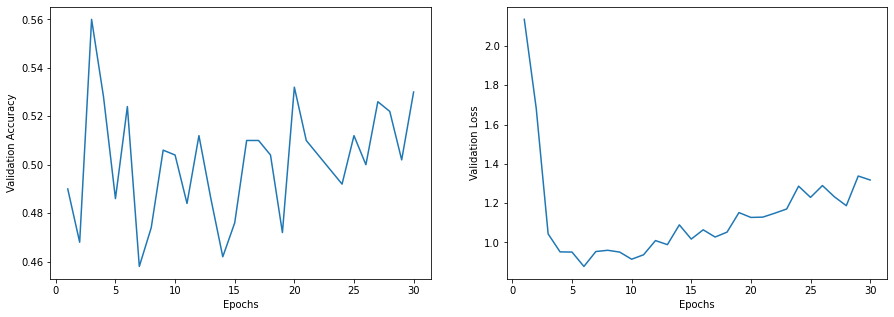

In [122]:
params_8 = [6, 512, 0.2, 0.018548666666666665]
hist_custom_8 = run_k_fold_params(x, y, build_custom_model, params_8, 30, 10, 5)

### 5 layers 512 units 0.3 dropout each layer

Fold 10/50
Fold 20/50
Fold 30/50
Fold 40/50
Fold 50/50

Max Average Accuracy: 55.6% 	 Num Epochs: 6 
Min Average Loss: 0.9 	 Num Epochs: 6 


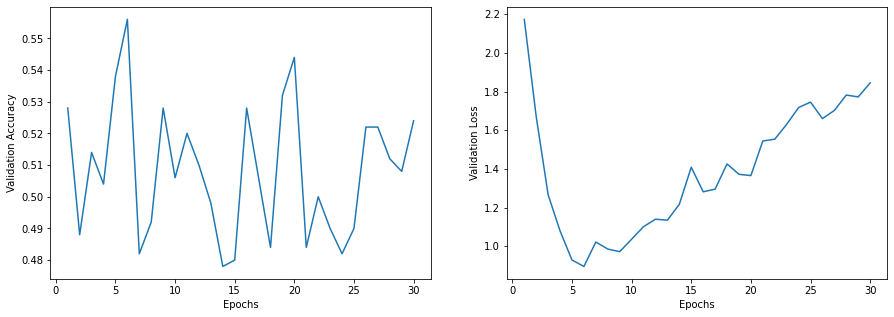

In [123]:
hist_custom_9 = run_k_fold_params(x, y, build_custom_model, [5, 512, 0.2, 0.018548666666666665], 30, 10, 5)

### 5 layers 512 units 0.3 dropout 

Fold 10/50
Fold 20/50
Fold 30/50
Fold 40/50
Fold 50/50

Max Average Accuracy: 57.0% 	 Num Epochs: 29 
Min Average Loss: 0.92 	 Num Epochs: 4 


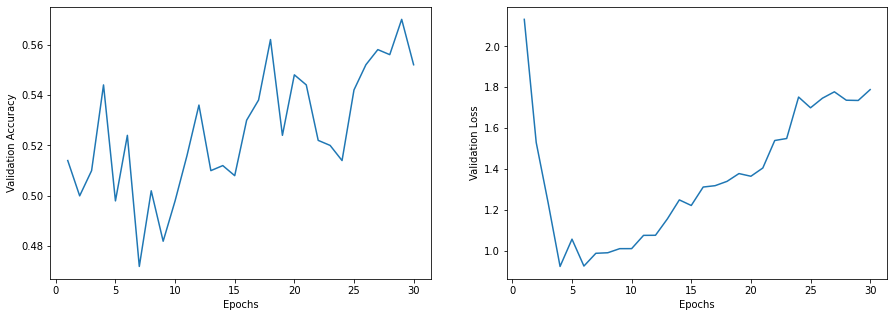

In [124]:
hist_custom_9 = run_k_fold_params(x, y, build_custom_model, [5, 512, 0.3, 0.018548666666666665], 30, 10, 5)

### 5 layers 512 units 0.4 dropout 

Fold 10/50
Fold 20/50
Fold 30/50
Fold 40/50
Fold 50/50

Max Average Accuracy: 51.8% 	 Num Epochs: 1 
Min Average Loss: 1.03 	 Num Epochs: 7 


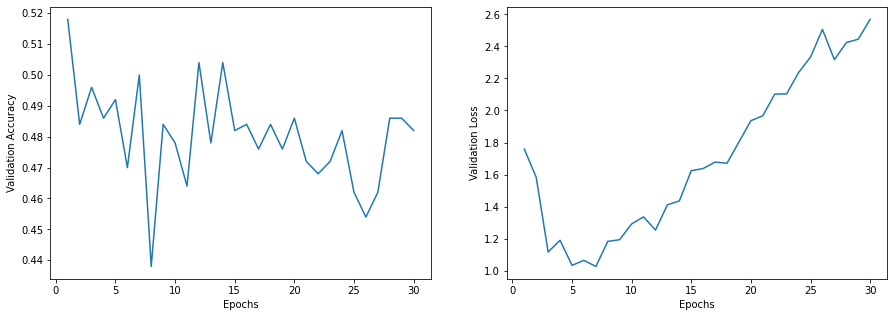

In [125]:
hist_custom_9 = run_k_fold_params(x, y, build_custom_model, [5, 512, 0.4, 0.018548666666666665], 30, 10, 5)

### 5 layers 512 units 0.25 dropout LR 0.01854

Fold 10/50
Fold 20/50
Fold 30/50
Fold 40/50
Fold 50/50

Max Average Accuracy: 53.4% 	 Num Epochs: 25 
Min Average Loss: 0.95 	 Num Epochs: 6 


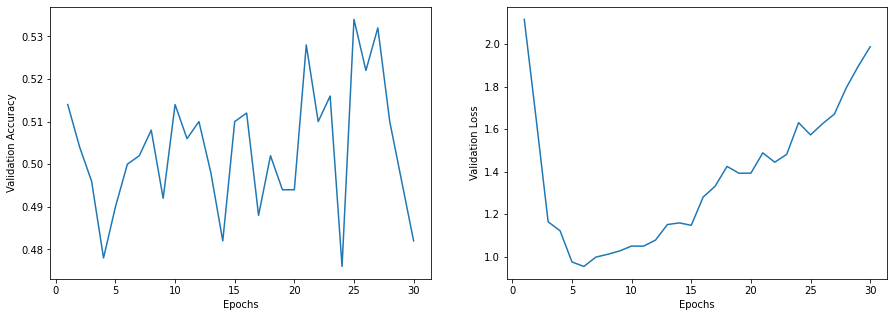

In [126]:
hist_custom_9 = run_k_fold_params(x, y, build_custom_model, [5, 512, 0.25, 0.018548666666666665], 30, 10, 5)

Fold 10/50
Fold 20/50
Fold 30/50
Fold 40/50
Fold 50/50

Max Average Accuracy: 55.2% 	 Num Epochs: 29 
Min Average Loss: 0.89 	 Num Epochs: 4 


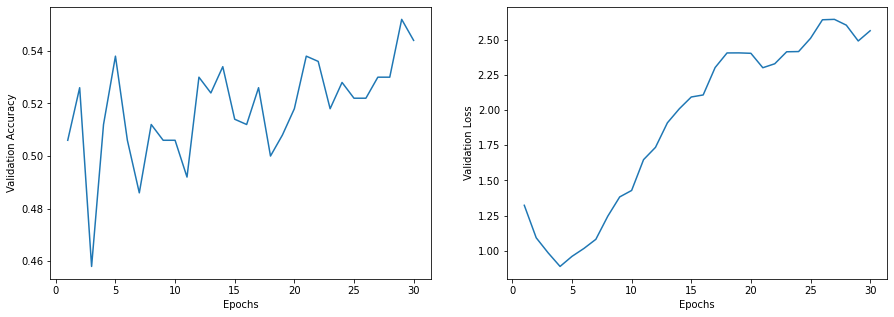

In [127]:
hist_custom_9 = run_k_fold_params(x, y, build_custom_model, [5, 256, 0.3, 0.018548666666666665], 30, 10, 5)

Fold 10/50
Fold 20/50
Fold 30/50
Fold 40/50
Fold 50/50

Max Average Accuracy: 52.8% 	 Num Epochs: 2 
Min Average Loss: 0.94 	 Num Epochs: 4 


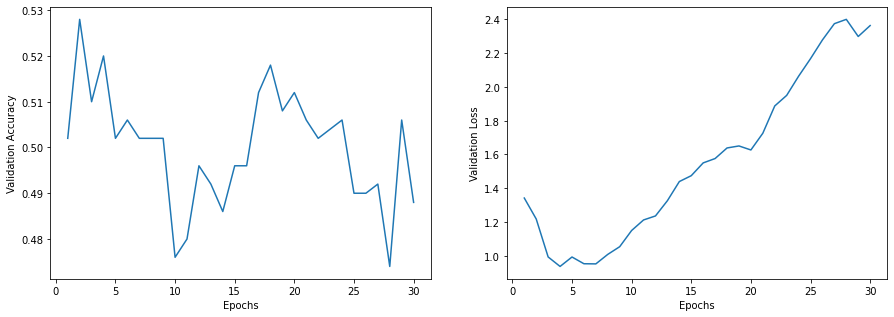

In [129]:
hist_custom_9 = run_k_fold_params(x, y, build_custom_model, [5, 400, 0.3, 0.01854], 30, 10, 5)

In [133]:
get_max_ave_acc_min_ave_loss(hist_custom_9[1],hist_custom_9[2])


Max Average Accuracy: 52.8% 	 Num Epochs: 2 
Min Average Loss: 0.94 	 Num Epochs: 4 


In [136]:
best_params_1 = [
    [6, 512, 0.3, 0.0185486],
    [6, 512, 0.2, 0.0185486],
    [5, 512, 0.3, 0.0185486],
    [6, 512, 0.2, 0.013],
    [5, 512, 0.3, 0.0185486]
]

Fold 10/50
Fold 20/50
Fold 30/50
Fold 40/50
Fold 50/50

Max Average Accuracy: 53.2% 	 Num Epochs: 3 
Min Average Loss: 0.94 	 Num Epochs: 8 


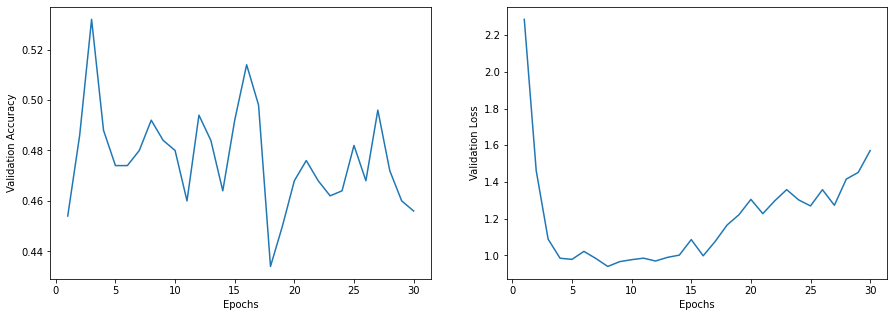


Max Average Accuracy: 53.2% 	 Num Epochs: 3 
Min Average Loss: 0.94 	 Num Epochs: 8 
Fold 10/50
Fold 20/50
Fold 30/50
Fold 40/50
Fold 50/50

Max Average Accuracy: 53.2% 	 Num Epochs: 3 
Min Average Loss: 0.9 	 Num Epochs: 7 


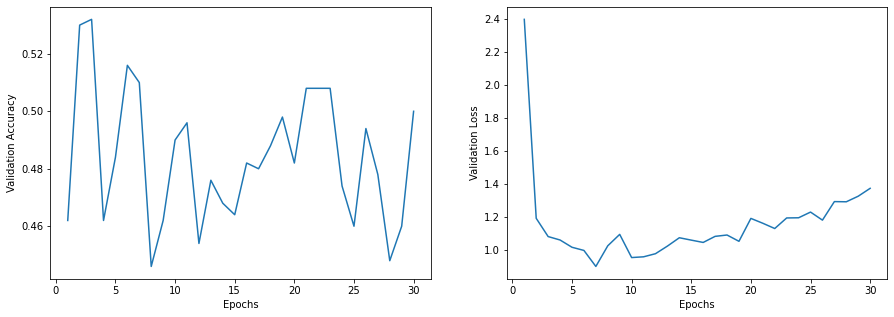


Max Average Accuracy: 53.2% 	 Num Epochs: 3 
Min Average Loss: 0.9 	 Num Epochs: 7 
Fold 10/50
Fold 20/50
Fold 30/50
Fold 40/50
Fold 50/50

Max Average Accuracy: 52.0% 	 Num Epochs: 5 
Min Average Loss: 0.93 	 Num Epochs: 5 


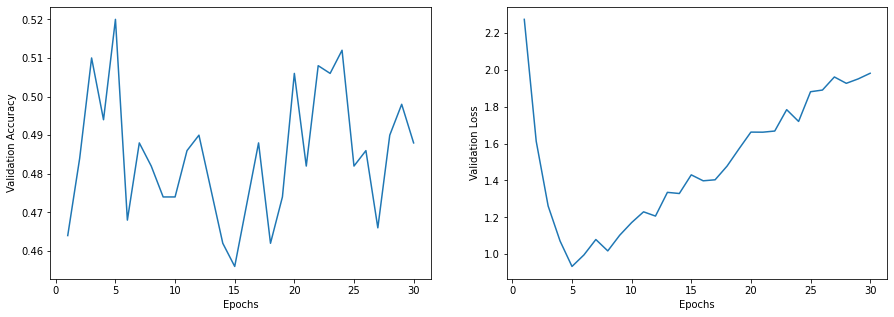


Max Average Accuracy: 52.0% 	 Num Epochs: 5 
Min Average Loss: 0.93 	 Num Epochs: 5 
Fold 10/50
Fold 20/50
Fold 30/50
Fold 40/50
Fold 50/50

Max Average Accuracy: 51.0% 	 Num Epochs: 12 
Min Average Loss: 0.89 	 Num Epochs: 5 


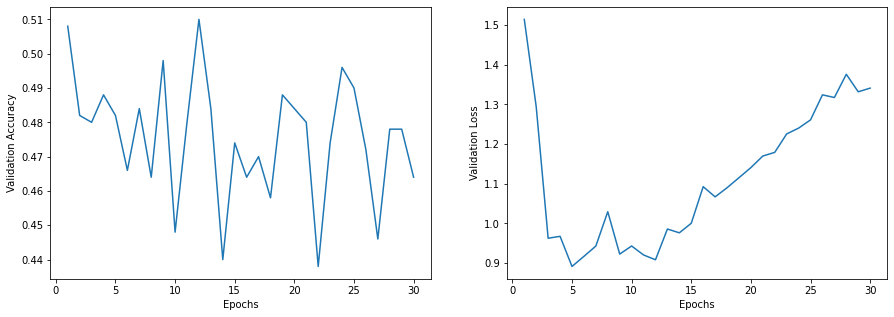


Max Average Accuracy: 51.0% 	 Num Epochs: 12 
Min Average Loss: 0.89 	 Num Epochs: 5 
Fold 10/50
Fold 20/50
Fold 30/50
Fold 40/50
Fold 50/50

Max Average Accuracy: 54.4% 	 Num Epochs: 13 
Min Average Loss: 0.9 	 Num Epochs: 6 


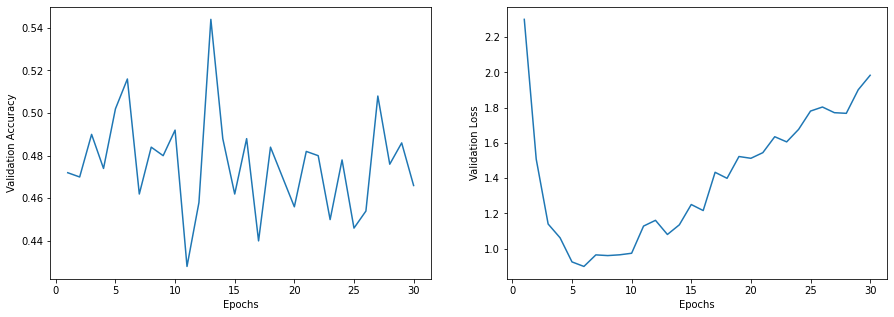


Max Average Accuracy: 54.4% 	 Num Epochs: 13 
Min Average Loss: 0.9 	 Num Epochs: 6 


In [137]:
x,y = get_data(files[1])
hist_game_3 = []
results_game_3 = []
for params in best_params_1:
    hist = run_k_fold_params(x,y,build_custom_model, params, 30, 10, 5)
    hist_game_3.append(hist)
    loss, acc = get_max_ave_acc_min_ave_loss(hist[1], hist[2])
    result_dict = {
        'acc': acc,
        'loss': loss,
        'params': params
    }
    results_game_3.append(result_dict)
    



In [138]:
results_game_3

[{'acc': 53.2, 'loss': 0.94, 'params': [6, 512, 0.3, 0.0185486]},
 {'acc': 53.2, 'loss': 0.9, 'params': [6, 512, 0.2, 0.0185486]},
 {'acc': 52.0, 'loss': 0.93, 'params': [5, 512, 0.3, 0.0185486]},
 {'acc': 51.0, 'loss': 0.89, 'params': [6, 512, 0.2, 0.013]},
 {'acc': 54.4, 'loss': 0.9, 'params': [5, 512, 0.3, 0.0185486]}]

preprocessed_no_sent_last_3_wt.csv
Fold 10/50
Fold 20/50
Fold 30/50
Fold 40/50
Fold 50/50

Max Average Accuracy: 53.0% 	 Num Epochs: 14 
Min Average Loss: 0.91 	 Num Epochs: 7 


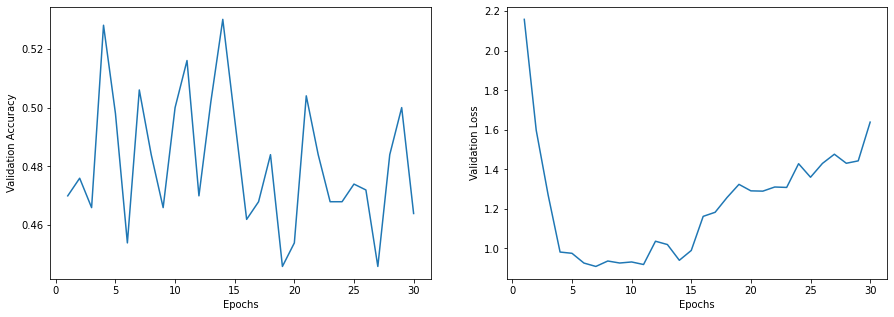


Max Average Accuracy: 53.0% 	 Num Epochs: 14 
Min Average Loss: 0.91 	 Num Epochs: 7 
Fold 10/50
Fold 20/50
Fold 30/50
Fold 40/50
Fold 50/50

Max Average Accuracy: 55.8% 	 Num Epochs: 1 
Min Average Loss: 0.92 	 Num Epochs: 6 


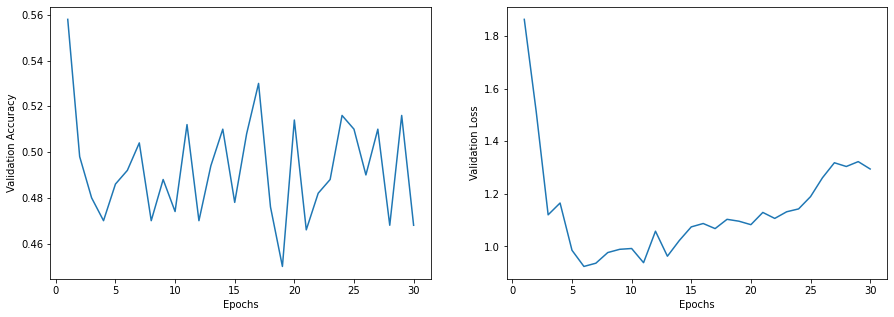


Max Average Accuracy: 55.8% 	 Num Epochs: 1 
Min Average Loss: 0.92 	 Num Epochs: 6 
Fold 10/50
Fold 20/50
Fold 30/50
Fold 40/50
Fold 50/50

Max Average Accuracy: 50.8% 	 Num Epochs: 8 
Min Average Loss: 0.94 	 Num Epochs: 5 


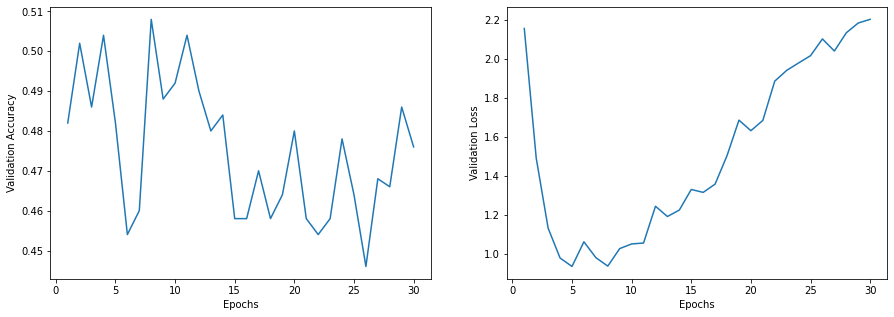


Max Average Accuracy: 50.8% 	 Num Epochs: 8 
Min Average Loss: 0.94 	 Num Epochs: 5 
Fold 10/50
Fold 20/50
Fold 30/50
Fold 40/50
Fold 50/50

Max Average Accuracy: 52.2% 	 Num Epochs: 15 
Min Average Loss: 0.86 	 Num Epochs: 5 


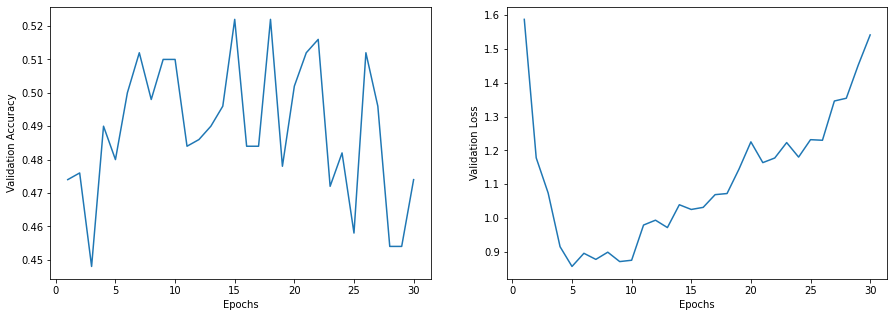


Max Average Accuracy: 52.2% 	 Num Epochs: 15 
Min Average Loss: 0.86 	 Num Epochs: 5 
Fold 10/50
Fold 20/50
Fold 30/50
Fold 40/50
Fold 50/50

Max Average Accuracy: 54.8% 	 Num Epochs: 22 
Min Average Loss: 0.92 	 Num Epochs: 8 


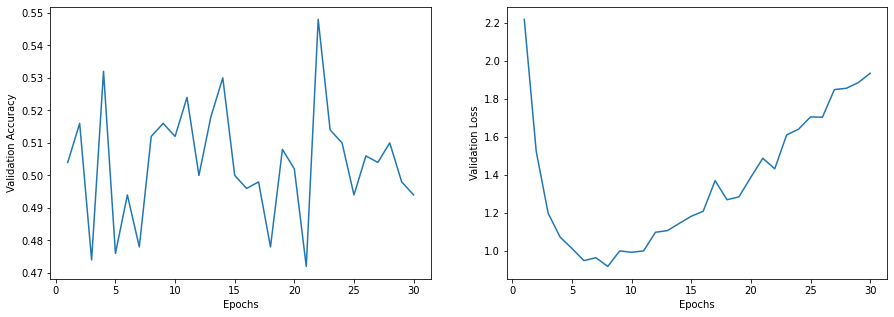


Max Average Accuracy: 54.8% 	 Num Epochs: 22 
Min Average Loss: 0.92 	 Num Epochs: 8 


In [139]:
print(files[2])
x,y = get_data(files[2])
hist_game_3wt = []
results_game_3wt = []
for params in best_params_1:
    hist = run_k_fold_params(x,y,build_custom_model, params, 30, 10, 5)
    hist_game_3wt.append(hist)
    loss, acc = get_max_ave_acc_min_ave_loss(hist[1], hist[2])
    result_dict = {
        'acc': acc,
        'loss': loss,
        'params': params
    }
    results_game_3wt.append(result_dict)
    

In [143]:
results_game_3_fixed = []
for res in results_game_3wt:
    new_dict = {
        'acc': res['acc'],
        'loss': res['loss'],
        'layers': res['params'][0],
        'units': res['params'][1],
        'dropout_rate': res['params'][2],
        'learn_rate': res['params'][3]
    }
    results_game_3_fixed.append(new_dict)

df_results_game_3_wt = pd.DataFrame.from_records(results_game_3_fixed)
df_results_game_3_wt.to_csv('../results/nn/3wt_game_no_sent_results.csv')

In [89]:
# each param combination
print('Parameter Combinations: ',len(resultsa)) 
# all hist, accuracy hist, loss hist
print('All Hist, Acc Hist, Loss, Hist: ', len(resultsa[0]))
# total folds
print('Total Folds', len(resultsa[0][0]))
# hist dictionary for each fold
# dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
print('Hist Dict Length', len(resultsa[0][0][0]))


Parameter Combinations:  2
All Hist, Acc Hist, Loss, Hist:  3
Total Folds 25
Hist Dict Length 4


RMS Default (1e-3): 56.8%
RMS 1e-4: 51.5%
Adam 1e-4: 49.9%
Adam 1e-3: 54.3%

### Keras Tune Build Model

In [46]:
def build_model_2(hp):
    model = keras.Sequential()
    # dense layers
    for i in range(hp.Int('num_layers', 1, 10)):
        model.add(
            layers.Dense(
                units= hp.Int(f'units_{i}', min_value=16, max_value=2048, step=32),
                activation= hp.Choice('activation', ['relu','tanh'])
            )   
        )
        if hp.Boolean('dropout'):
            model.add(layers.Dropout(
                rate=hp.Float('do_rate', min_value=0.1, max_value=0.8, step=0.1)
                )
            )
    # dropout layer
    # output layer
    model.add(layers.Dense(1, activation='sigmoid'))

    #learning rate
    learning_rate = hp.Float('lr', min_value=1e-5, max_value=1e-1, sampling='log')
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
        loss=hp.Choice('loss_func', ['binary_crossentropy','binary_focal_crossentropy']),
        metrics=['accuracy']
    )

    return model

build_model_2(keras_tuner.HyperParameters())

#### Create Tuner

In [47]:
tuner = keras_tuner.BayesianOptimization(
    hypermodel = build_model_2,
    objective='val_accuracy',
    max_trials=300,
    
    # executions_per_trial=1, # how many times to try the same combination of hps
    overwrite=True,
    directory='./nn',
)
tuner.search_space_summary()
# tuner.search(x, y, batch_size=64, epochs=30)

Search space summary
Default search space size: 6
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 10, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 2048, 'step': 32, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.1, 'step': None, 'sampling': 'log'}
loss_func (Choice)
{'default': 'binary_crossentropy', 'conditions': [], 'values': ['binary_crossentropy', 'binary_focal_crossentropy'], 'ordered': False}


#### Split data for Test and Train

In [48]:
x,y = get_data(files[3])
X_val, X_train = get_val_and_train(x, 1, num_val_samples = len(x) // 5)
y_val, y_train = get_val_and_train(y, 1, num_val_samples = len(x) // 5)


#### Run Search

In [49]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                    mode="min",
                    patience = 10,
                    verbose=1)


In [50]:
tuner.search(
    X_train, 
    y_train, 
    epochs=50, 
    # batch_size=64, 
    validation_data=(X_val, y_val),
    callbacks=[early_stopping_callback]
)

Trial 300 Complete [00h 00m 02s]
val_accuracy: 0.5714285969734192

Best val_accuracy So Far: 0.8571428656578064
Total elapsed time: 00h 26m 48s
INFO:tensorflow:Oracle triggered exit


#### Search Results

In [51]:
tuner.results_summary()

Results summary
Results in ./nn\untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 4
units_0: 880
activation: tanh
dropout: False
lr: 0.005323221907420629
loss_func: binary_crossentropy
units_1: 1968
units_2: 1808
units_3: 2032
units_4: 752
units_5: 2000
units_6: 688
units_7: 112
units_8: 1328
do_rate: 0.30000000000000004
units_9: 304
Score: 0.8571428656578064
Trial summary
Hyperparameters:
num_layers: 6
units_0: 1424
activation: tanh
dropout: False
lr: 0.028161720337459773
loss_func: binary_crossentropy
units_1: 1168
units_2: 304
units_3: 1008
units_4: 1360
units_5: 80
units_6: 1744
units_7: 16
units_8: 368
do_rate: 0.7000000000000001
units_9: 1136
Score: 0.8571428656578064
Trial summary
Hyperparameters:
num_layers: 9
units_0: 368
activation: relu
dropout: True
lr: 0.042259707602848806
loss_func: binary_focal_crossentropy
units_1: 688
units_2: 1872
units_3: 208
units_4: 1456
units_5: 1968
units_6: 784
units_7: 1360
units_8: 528
do_rate: 0.8
units_9: 168

#### Get Best Model Summary

In [52]:
models = tuner.get_best_models(2)
best_model = models[0]
best_model.build(input_shape = (82,142))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (82, 880)                 125840    
                                                                 
 dense_1 (Dense)             (82, 1968)                1733808   
                                                                 
 dense_2 (Dense)             (82, 1808)                3559952   
                                                                 
 dense_3 (Dense)             (82, 2032)                3675888   
                                                                 
 dense_4 (Dense)             (82, 1)                   2033      
                                                                 
Total params: 9,097,521
Trainable params: 9,097,521
Non-trainable params: 0
_________________________________________________________________


#### Get Best HyperParams

In [ ]:
# get best hps
best_hps = tuner.get_best_hyperparameters(1)
model_best = build_model_2(best_hps[0])

#### Repeated KFold Using Best HPs

In [25]:
def build_model_11():
    model = tf.keras.Sequential([ 
        tf.keras.layers.Dense(1072, activation="relu"),
        tf.keras.layers.Dropout(0.8),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.000027556), 
        loss='binary_crossentropy', 
        metrics=['accuracy']
    )

    return model


In [ ]:
def run_k_fold_hps(x, y, build_m, hps, num_epochs=30, k=10, n_repeats=10):
    num_val_samples = len(x) // k
    all_scores = [] 
    
    all_histories = []
    acc_histories = []
    loss_histories = []
    curr_fold = 0
    total_folds = k*n_repeats
    # cv = RepeatedKFold(10, 10, 99)
    for n in range(n_repeats):
        xs, ys = shuffle_data(x,y,n)
        for i in range(k):
            curr_fold = curr_fold + 1
            if curr_fold % 5 == 0:
                print(f"Fold {curr_fold}/{total_folds}")
 
            X_val, X_train = get_val_and_train(xs, i, num_val_samples)
            y_val, y_train = get_val_and_train(ys, i, num_val_samples)

            model = build_m(hps[0])
            
            history = model.fit(
                    X_train, y_train, 
                    validation_data=(X_val, y_val),
                    epochs=num_epochs, batch_size=16, verbose=0
                )
            
            all_histories.append(history.history)
            acc_histories.append(history.history['val_accuracy'])
            loss_histories.append(history.history['val_loss'])

    get_max_ave_acc_min_ave_loss(acc_histories, loss_histories)
    plot_ave_acc_and_loss_histories(acc_histories, loss_histories)
    return [all_histories, acc_histories, loss_histories]

In [22]:
model_11 = build_model_11()

Fold 10/100
Fold 20/100
Fold 30/100
Fold 40/100
Fold 50/100
Fold 60/100
Fold 70/100
Fold 80/100
Fold 90/100
Fold 100/100

Max Average Accuracy: 51.3% 	 Num Epochs: 1 
Min Average Loss: 0.71 	 Num Epochs: 1 


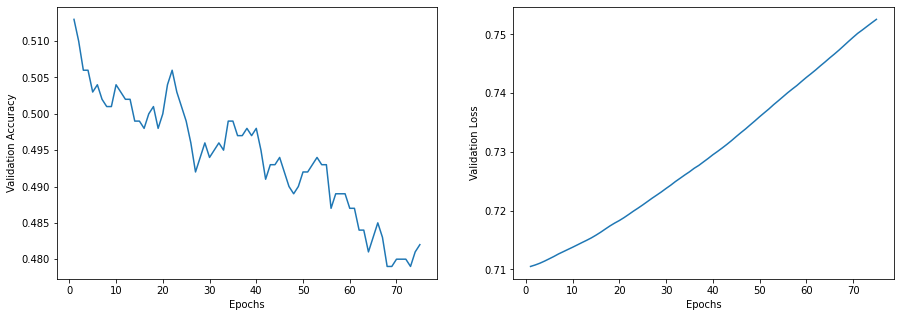

In [26]:
hist_11 = run_k_fold(x, y, build_model_11, 75, 10, 10)

Fold 10/50
Fold 20/50
Fold 30/50
Fold 40/50
Fold 50/50

Max Average Accuracy: 67.6% 	 Num Epochs: 25 
Min Average Loss: 0.56 	 Num Epochs: 2 


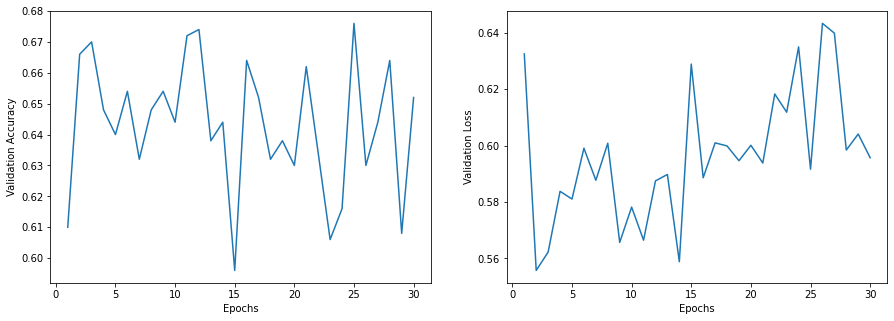

In [ ]:
hists_best = run_k_fold_hps(x, y, model_best, 30, 10, 5)


In [ ]:
len(hists_best[0])

50

In [ ]:
hists_best2 = run_k_fold_hps(x, y, build_model_2, best_hps, 50, 10, 5)

In [ ]:
def plot_train_val_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

    blue_dots = 'bo'
    solid_blue_line = 'b'

    plt.plot(epochs, loss, blue_dots, label = 'Training loss')
    plt.plot(epochs, val_loss, solid_blue_line, label = 'Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()
    
def plot_train_val_acc(history):
    plt.clf()

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
        
    epochs = range(1, len(acc) + 1)

    blue_dots = 'bo'
    solid_blue_line = 'b'
        
    plt.plot(epochs, acc, blue_dots, label = 'Training Accuracy')
    plt.plot(epochs, val_acc, solid_blue_line, label = 'Validation Accuracy')
    plt.title('Training and validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

def plot_train_val_loss_acc(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(1, len(acc) + 1)
    blue_dots = 'bo'
    solid_blue_line = 'b'

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    # plt.plot(epochs_range, acc, label='Training Accuracy')
    # plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    
 
    plt.plot(epochs_range, acc, blue_dots, label = 'Training Accuracy')
    plt.plot(epochs_range, val_acc, solid_blue_line, label = 'Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, blue_dots, label='Training Loss')
    plt.plot(epochs_range, val_loss, solid_blue_line, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
  
def compare_loss_and_acc(hist1, hist2, title1, title2): 
    min_epochs = min(len(hist1.history['loss']), len(hist2.history['loss']))
    
    train_loss_1 = hist1['loss'][:min_epochs]
    val_loss_1 = hist1['val_loss'][:min_epochs]

    train_loss_2 = hist2['loss'][:min_epochs]
    val_loss_2 = hist2['val_loss'][:min_epochs]


    train_acc_1 = hist1['accuracy'][:min_epochs]
    val_acc_1 = hist1['val_accuracy'][:min_epochs]

    train_acc_2 = hist2['accuracy'][:min_epochs]
    val_acc_2 = hist2['val_accuracy'][:min_epochs]

    epochs = range(1, min_epochs + 1)

    blue_dots = 'bo'
    solid_blue_line = 'b'
    red_dots = 'ro'
    solid_red_line = 'r'

    plt.figure(figsize=(15,5))
    plt.subplot(1, 2, 1)

    plt.plot(epochs, train_loss_1, blue_dots, label = f'{title1} Training Loss')
    plt.plot(epochs, val_loss_1, solid_blue_line, label = f'{title1} Validation Loss')
    plt.plot(epochs, train_loss_2, red_dots, label = f'{title2} Training Loss')
    plt.plot(epochs, val_loss_2, solid_red_line, label = f'{title2} Validation Loss')
    # plt.title('Loss With Dropout Layers')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc_1, blue_dots, label = f'{title1} Training Accuracy')
    plt.plot(epochs, val_acc_1, solid_blue_line, label = f'{title1} Validation Accuracy')
    plt.plot(epochs, train_acc_2, red_dots, label = f'{title2} Training Accuracy')
    plt.plot(epochs, val_acc_2, solid_red_line, label = f'{title2} Validation Accuracy')
    # plt.title('Accuracy With Dropout Layers')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.show()

def compare_acc(hist1, hist2, title1, title2): 
    min_epochs = min(len(hist1.history['accuracy']), len(hist2.history['accuracy']))
    acc = hist1.history['accuracy'][:min_epochs]
    val_acc = hist1.history['val_accuracy'][:min_epochs]
    acc_drop = hist2.history['accuracy'][:min_epochs]
    val_acc_drop = hist2.history['val_accuracy'][:min_epochs]
    
    epochs = range(1, min_epochs + 1)

    blue_dots = 'bo'
    solid_blue_line = 'b'
    red_dots = 'ro'
    solid_red_line = 'r'

    plt.plot(epochs, acc, blue_dots, label = f'{title1} Training Accuracy')
    plt.plot(epochs, val_acc, solid_blue_line, label = f'{title1} Validation Accuracy')
    plt.plot(epochs, acc_drop, red_dots, label = f'{title2} Training Accuracy')
    plt.plot(epochs, val_acc_drop, solid_red_line, label = f'{title2} Validation Accuracy')
    # plt.title('Accuracy With Dropout Layers')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()